# Imports

In [1]:

!pip install -U cade
!pip install git+https://github.com/valedica/gensim.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 99 kB 3.1 MB/s 
     |████████████████████████████████| 132 kB 30.7 MB/s 
     |████████████████████████████████| 8.9 MB 41.6 MB/s 
     |████████████████████████████████| 79 kB 8.8 MB/s 
     |████████████████████████████████| 138 kB 46.0 MB/s 
     |████████████████████████████████| 127 kB 49.8 MB/s 
  Created wheel for smart-open: filename=smart_open-1.10.0-py3-none-any.whl size=90641 sha256=908ccc116e93e607cf53219db0bcaec3c62333bf13d5a2269b6cadcafd3bb12d
  Stored in directory: /root/.cache/pip/wheels/1f/e5/fc/7412935a7184efc8ad377e948c81b1cc99b6a02eb8dc7c918c
Successfully built smart-open
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: smart-open
    Found existing installation: smart-open 5.2.1
    Uninstalling 

In [2]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
from gensim.models import Word2Vec
from collections import Counter
import random
import numpy as np
import pandas as pd
from collections import Counter
from cade.cade import CADE
from scipy.spatial.distance import cosine
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mc

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#function to find abs.frequency and medium similiraty of 5 most similar words to a given word

In [ ]:
os.chdir('/content/drive/MyDrive/Magistrale/Secondo semestre/DS/Progetto/Sentences_nl')

In [5]:
def getsentences(file_name):
  os.chdir('/content/drive/MyDrive/Magistrale/Secondo semestre/DS/Progetto/Sentences_nl')
  sentences = []

  with open(file_name + '_nl.txt', 'r') as fp:
      for line in fp:
          x = line[1:-2]
          x = x.replace('\'','')
          x = x.replace(' ', '')
          x = x.split(',')

          sentences.append(x)
          
  return sentences

In [6]:
#function to get the frequency percentile of a word 
def get_percentile(word):
  sentences_names = ['Christian_sentences', 'Islam_sentences', 'Hinduism_sentences', 'Buddhism_sentences']
  for sentences_name in sentences_names:
    print(sentences_name)
    sentences = getsentences(sentences_name)
    words = []
    for i in range(len(sentences)):
      for j in range(len(sentences[i])):
        words.append(sentences[i][j])

    word_count = Counter(words)
    keys = word_count.keys()

    list_check = [w[0] for w in word_count.most_common(len(keys))]
    print(len(list_check))
    pos = list_check.index(word)
    print(pos)
    print(round((len(keys) - pos)*100/len(keys)))

# First question

## Check word frequency percentile

In [9]:
words =['woman', 'poor', 'wisdom', 'sins', 'death']

for word in words:
  print('***'+word+'***')
  get_percentile(word)

***woman***
Christian_sentences
19157
154
99
Islam_sentences
22069
509
98
Hinduism_sentences
18874
642
97
Buddhism_sentences
19699
1455
93
***poor***
Christian_sentences
19157
326
98
Islam_sentences
22069
517
98
Hinduism_sentences
18874
2829
85
Buddhism_sentences
19699
1189
94
***wisdom***
Christian_sentences
19157
255
99
Islam_sentences
22069
237
99
Hinduism_sentences
18874
306
98
Buddhism_sentences
19699
130
99
***sins***
Christian_sentences
19157
261
99
Islam_sentences
22069
187
99
Hinduism_sentences
18874
1727
91
Buddhism_sentences
19699
2301
88
***death***
Christian_sentences
19157
125
99
Islam_sentences
22069
121
99
Hinduism_sentences
18874
251
99
Buddhism_sentences
19699
55
100


## Functions

In [ ]:
def explore_word(word, n_emb, n_words, holytext): #word to explore, number of embeddings to consider, number of similar words, holy text to consider

  os.chdir('/content/drive/MyDrive/Magistrale/Secondo semestre/DS/Progetto/'+ holytext + '_nl_embeddings')
  holytext_2 = holytext
  holytext = holytext.lower()

  #get n_emb bible embeddings
  embeddings = []
  for it in range(n_emb):
    model = Word2Vec.load(holytext.lower() + '_' + str(it) + '.model')
    embeddings.append(model)

  #get list of the n_words most similar words, model by model
  words = []
  for it in range(n_emb):
    for tupl in embeddings[it].wv.most_similar(word)[:n_words]:
      words.append(tupl[0])

  #get dictionary with unique words and frequency
  c = Counter(words)
  word_frequencies = dict(c)

  #get dictionary with unique words and medium similarity
  init = [0] * len(np.unique(words))
  word_similarities = dict(zip(np.unique(words), init))

  for it in range(n_emb):
    for tupl in embeddings[it].wv.most_similar(word)[:n_words]:
      word_similarities[tupl[0]] += tupl[1]
  for word in np.unique(words):
    word_similarities[word] = word_similarities[word] / word_frequencies[word]

  #two dfs to merge and get all the information in one df
  df_1 = pd.DataFrame(list(word_frequencies.items()), columns=['Words','Abs.frequency'])
  df_2 = pd.DataFrame(list(word_similarities.items()), columns=['Words','Med.similarity'])
  #normalize similarity to allow comparisons between embeddings
  normalized_similarity = (df_2['Med.similarity']-df_2['Med.similarity'].min())/(df_2['Med.similarity'].max() - df_2['Med.similarity'].min()) 
  df = pd.merge(df_1, df_2, on = 'Words')
  df['Med.similarity(norm.)'] = normalized_similarity

  #add holy text column to dataset
  df['HolyText'] = [holytext_2] * len(df)

  return df

In [ ]:
def explore_word_CADE(word, n_emb, n_words, holytext): #word to explore, number of embeddings to consider, number of similar words, holy text to consider

  os.chdir('/content/drive/MyDrive/Magistrale/Secondo semestre/DS/Progetto/Embeddings_CADE')
  holytext_2 = holytext

  #get n_emb bible embeddings
  embeddings = []
  for it in range(n_emb):
    model = Word2Vec.load(holytext + '_nl_cade' + str(it) + '.model')
    embeddings.append(model)

  #get list of the n_words most similar words, model by model
  words = []
  for it in range(n_emb):
    for tupl in embeddings[it].wv.most_similar(word)[:n_words]:
      words.append(tupl[0])

  #get dictionary with unique words and frequency
  c = Counter(words)
  word_frequencies = dict(c)

  #get dictionary with unique words and medium similarity
  init = [0] * len(np.unique(words))
  word_similarities = dict(zip(np.unique(words), init))

  for it in range(n_emb):
    for tupl in embeddings[it].wv.most_similar(word)[:n_words]:
      word_similarities[tupl[0]] += tupl[1]
  for word in np.unique(words):
    word_similarities[word] = word_similarities[word] / word_frequencies[word]

  #two dfs to merge and get all the information in one df
  df_1 = pd.DataFrame(list(word_frequencies.items()), columns=['Words','Abs.frequency'])
  df_2 = pd.DataFrame(list(word_similarities.items()), columns=['Words','Med.similarity'])
  #normalize similarity to allow comparisons between embeddings
  normalized_similarity = (df_2['Med.similarity']-df_2['Med.similarity'].min())/(df_2['Med.similarity'].max() - df_2['Med.similarity'].min()) 
  df = pd.merge(df_1, df_2, on = 'Words')
  df['Med.similarity(norm.)'] = normalized_similarity

  #add holy text column to dataset
  df['HolyText'] = [holytext_2] * len(df)

  return df

In [ ]:
def df_forheatmap(column, word, nemb, nwords):
  dfs_list = []
  holy_textes = ['Bible', 'Quran', 'VedasUpanishads', 'Tripitaka']

  for text in holy_textes:
    dfs_list.append(explore_word(word, nemb, nwords, text))

  result = pd.concat(dfs_list, ignore_index=True)
  df = result[['Words', column, 'HolyText']]
  df_hm = df.pivot_table(index='HolyText', columns='Words', values=column)

  return df_hm

In [ ]:
def df_forheatmap_CADE(column, word, nemb, nwords):
  dfs_list = []
  holy_textes = ['Bible', 'Quran', 'VedasUpanishads', 'Tripitaka']

  for text in holy_textes:
    dfs_list.append(explore_word_CADE(word, nemb, nwords, text))

  result = pd.concat(dfs_list, ignore_index=True)
  df = result[['Words', column, 'HolyText']]
  df_hm = df.pivot_table(index='HolyText', columns='Words', values=column)

  return df_hm

In [ ]:
def plotheatmap(df_hm, word, column):
  plt.figure(figsize=(20,4))
  cmap = sns.color_palette("Greens", as_cmap=True) 

  if(column == 'Abs.frequency'):
    bounds = [1, 8, 15, 22, 30]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    hm = sns.heatmap(df_hm, cmap=cmap, norm =norm, cbar_kws={"shrink": 1.2}, linewidths=1)

  elif((column == 'Med.similarity') or (column == 'Med.similarity(norm.)')):
    hm = sns.heatmap(df_hm, cmap=cmap, cbar_kws={"shrink": 1.2}, linewidths=1)

  else:
    print('Colonna sbagliata')
    return

  hm.set_xlabel(xlabel = 'Words', fontsize = 16)
  hm.set_ylabel(ylabel = column , fontsize = 17)
  hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
  hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
  hm.axes.set_title(column + " through 30 embeddings of 5 most similar words to "+ word,fontsize=20)
  hm.set_facecolor('lightgrey')
  plt.savefig('prova')

In [ ]:
def plotheatmap_2(column, word, nemb, nwords):#column=abs.frequency or med.similarity
  dfs_list = []
  holy_textes = ['Bible', 'Quran', 'VedasUpanishads', 'Tripitaka']

  for text in holy_textes:
    dfs_list.append(explore_word(word, nemb, nwords, text))

  result = pd.concat(dfs_list, ignore_index=True)
  df = result[['Words', column, 'HolyText']]
  df_hm = df.pivot_table(index='HolyText', columns='Words', values=column)
  #df_hm = df_hm.fillna(0)

  plt.figure(figsize=(20,4))
  cmap = sns.color_palette("Greens", as_cmap=True) 

  if(column == 'Abs.frequency'):
    bounds = [1, 8, 15, 22, 30]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    hm = sns.heatmap(df_hm, cmap=cmap, norm =norm, cbar_kws={"shrink": 1.2}, linewidths=1)

  elif((column == 'Med.similarity') or column == 'Med.similarity(norm.)'):
    hm = sns.heatmap(df_hm, cmap=cmap, cbar_kws={"shrink": 1.2}, linewidths=1)

  else:
    print('Colonna sbagliata')
    return

  hm.set_xlabel(xlabel = 'Words', fontsize = 16)
  hm.set_ylabel(ylabel = column , fontsize = 17)
  hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 14)
  hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 14)
  hm.axes.set_title(column + " through 30 embeddings of 5 most similar words to woman",fontsize=20)
  hm.set_facecolor('lightgrey')


## Results

In [ ]:
df_w2v = df_forheatmap('Abs.frequency','woman', 30, 5)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
df_cade = df_forheatmap_CADE('Abs.frequency', 'woman', 30, 5)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


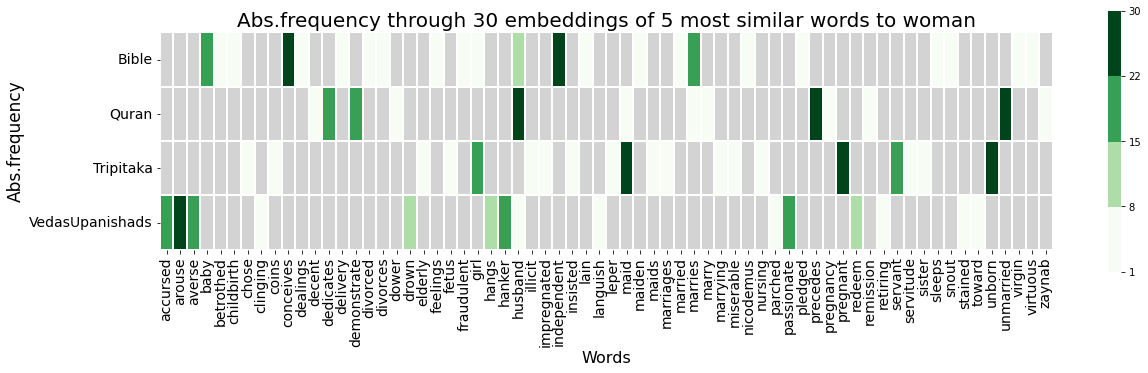

In [ ]:
plotheatmap(df_cade, 'Abs.frequency')

In [ ]:
plotheatmap(df_w2v, 'Abs.frequency')

TypeError: ignored

In [ ]:
df_w2v = df_forheatmap('Abs.frequency','children', 30, 5)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


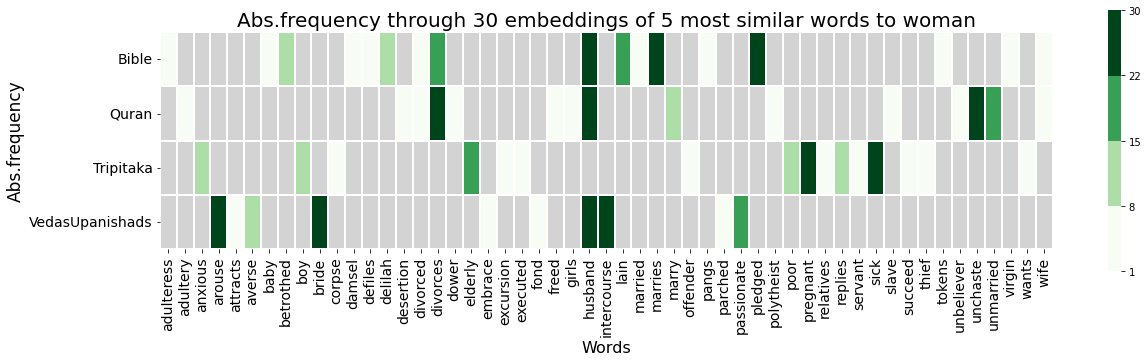

In [ ]:
plotheatmap(df_w2v, 'woman','Abs.frequency')

In [ ]:
df_w2v = df_forheatmap_CADE('Abs.frequency','children', 30, 5)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


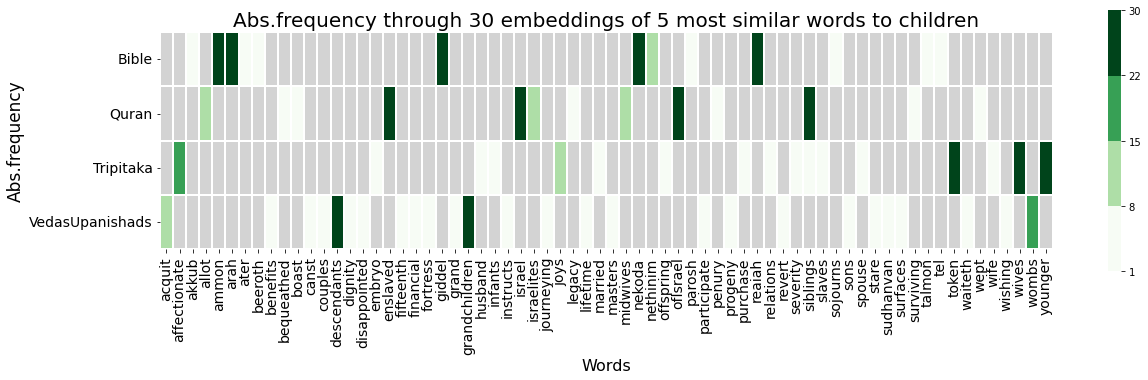

In [ ]:
plotheatmap(df_w2v, 'children','Abs.frequency')

In [ ]:
df_w2v = df_forheatmap('Abs.frequency','family', 30, 5)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


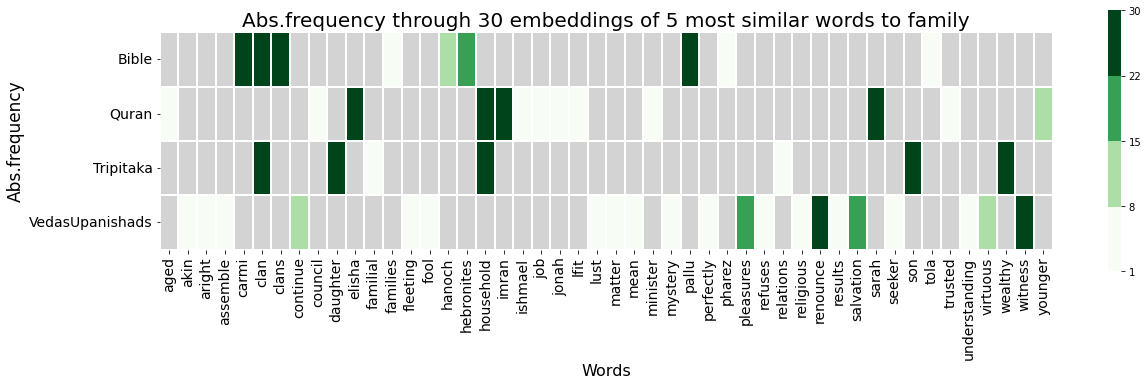

In [ ]:
plotheatmap(df_w2v, 'family','Abs.frequency')

In [ ]:
df_w2v = df_forheatmap('Abs.frequency','wisdom', 30, 5)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


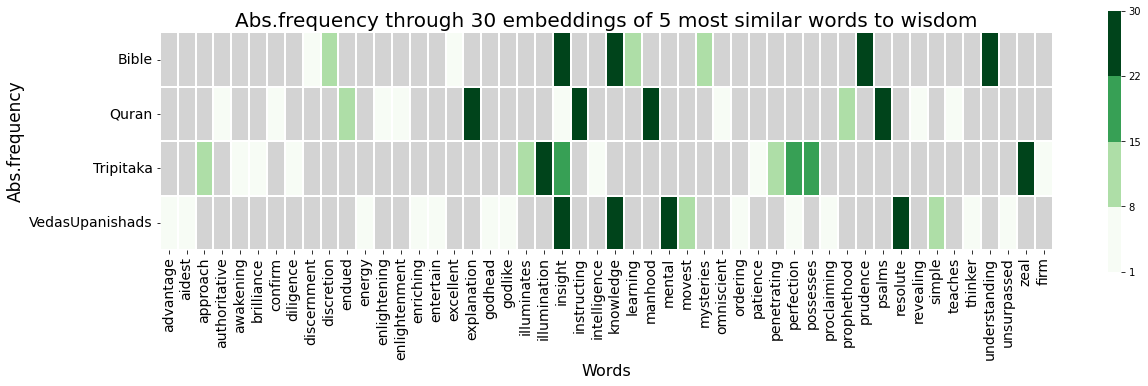

In [ ]:
plotheatmap(df_w2v, 'wisdom','Abs.frequency')

In [ ]:
df_w2v = df_forheatmap('Abs.frequency','peace', 30, 5)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


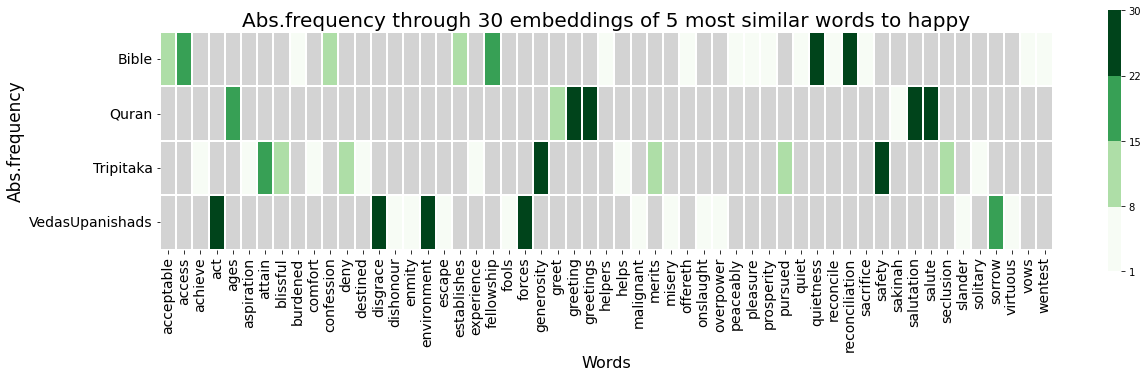

In [ ]:
plotheatmap(df_w2v, 'happy','Abs.frequency')

In [ ]:
df_w2v = df_forheatmap('Abs.frequency','', 30, 5)

In [ ]:
df_w2v = df_forheatmap('Abs.frequency','death', 30, 5)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


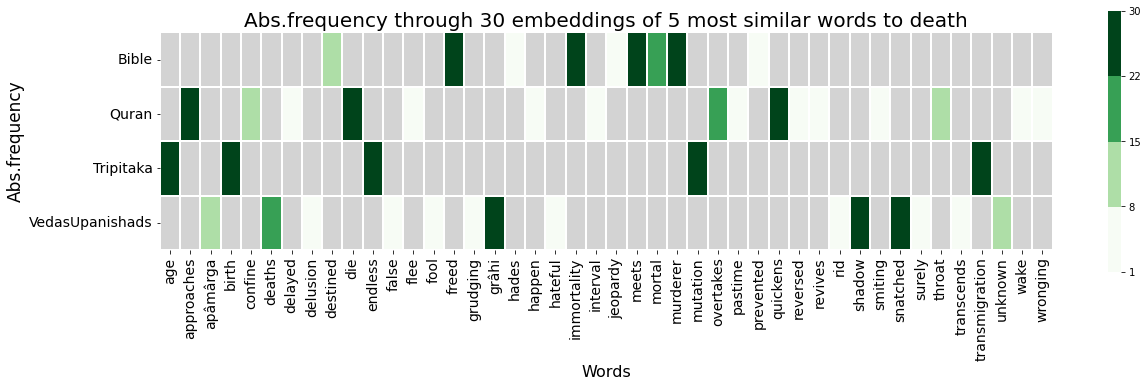

In [ ]:
plotheatmap(df_w2v, 'death','Abs.frequency')

In [ ]:
df_w2v = df_forheatmap_CADE('Abs.frequency','sin', 30, 5)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


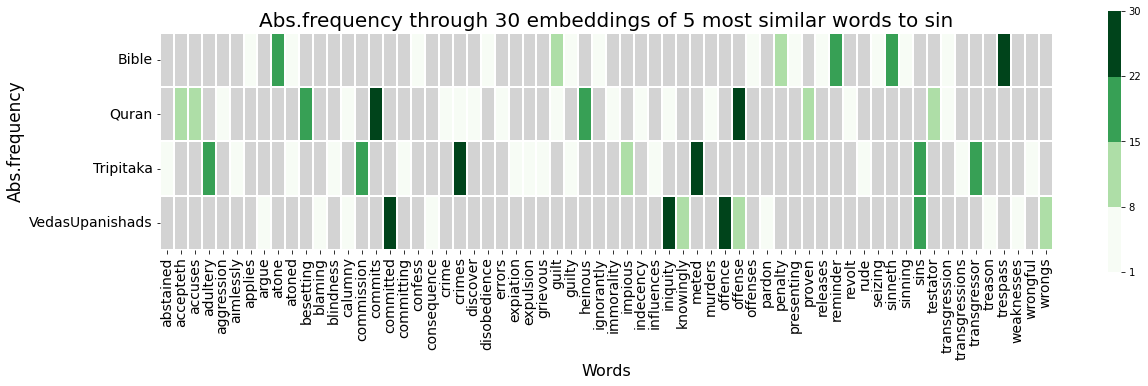

In [ ]:
plotheatmap(df_w2v, 'sin','Abs.frequency')

In [ ]:
df_w2v = df_forheatmap('Abs.frequency','shame', 30, 5)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


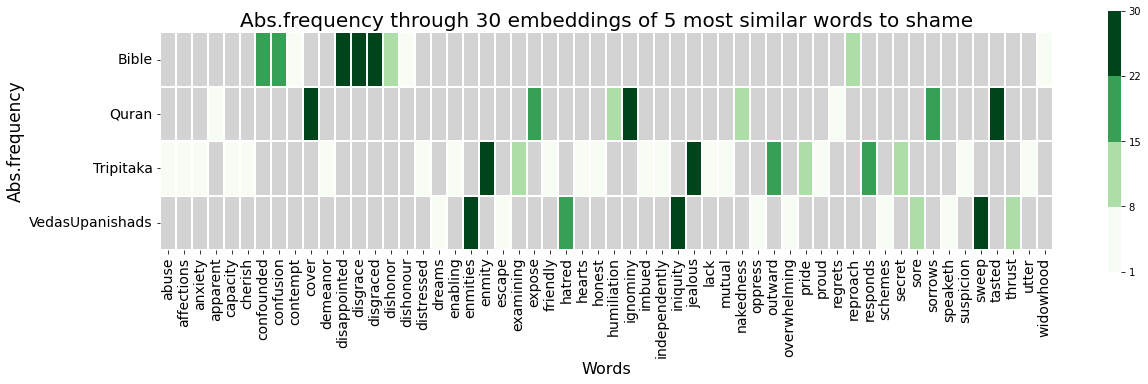

In [ ]:
plotheatmap(df_w2v, 'shame','Abs.frequency')

# Second question

## Functions

In [ ]:
os.chdir('/content/drive/MyDrive/Magistrale/Secondo semestre/DS/Progetto/Embeddings_CADE')

In [ ]:
#function to compare a word of an embeddings with the others
def compare_word2(word_to_study, holytext1, holytext2):

  #get n_emb embeddings
  embeddings1 = []
  for it in range(30):
    model = Word2Vec.load(holytext1 + '_nl_cade' + str(it) + '.model')
    embeddings1.append(model)

  embeddings2 = []
  for it in range(30):
    model = Word2Vec.load(holytext2 + '_nl_cade' + str(it) + '.model')
    embeddings2.append(model)

  #get list of the n_words most similar words, model by model
  words = []
  for it in range(30):
    word_vector = embeddings1[it].wv[word_to_study]
    for tupl in embeddings2[it].wv.most_similar(positive=[word_vector])[:10]:
      words.append(tupl[0])

  #get dictionary with unique words and frequency
  c = Counter(words)
  word_frequencies = dict(c)

  #get dictionary with unique words and medium similarity
  init = [0] * len(np.unique(words))
  word_similarities = dict(zip(np.unique(words), init))

  for it in range(30):
    word_vector = embeddings1[it].wv[word_to_study]
    for tupl in embeddings2[it].wv.most_similar(positive=[word_vector])[:10]:
      word_similarities[tupl[0]] += tupl[1]
  for word in np.unique(words):
    word_similarities[word] = word_similarities[word] / word_frequencies[word]

  df = pd.DataFrame(list(word_similarities.items()), columns=['Words','Med.similarity'])
  df = df.sort_values(by=['Med.similarity'], ascending=False)
  df = df.head(n=10)
  return df

## Results

In [ ]:
holytexts = ['Bible', 'Quran', 'Tripitaka', 'VedasUpanishads']
holytexts.remove('Bible')

for text in holytexts:
  print('***' + text +'***')
  df = compare_word2('jesus', 'Bible', text)
  print(df)

***Quran***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


         Words  Med.similarity
52       jesus        0.444103
32   effectual        0.394021
63    priority        0.391012
57        omit        0.386032
59  perceiving        0.383336
11      begged        0.381515
95      untrue        0.380948
97   vindicate        0.380548
53      joking        0.380518
34  encounters        0.380484
***Tripitaka***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


           Words  Med.similarity
64       talking        0.402373
26  disheartened        0.394797
45      pledging        0.387983
1       admitted        0.386864
62    sunakṣatra        0.379802
70     unwilling        0.379511
52       reputed        0.379269
32          heed        0.378623
24    derogatory        0.378491
66        udāyin        0.378347
***VedasUpanishads***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


           Words  Med.similarity
70    practicing        0.407554
12         buyer        0.395309
102       wretch        0.394719
10            bo        0.386422
24    describing        0.385509
78     repairing        0.382564
54      maturity        0.381507
55            mo        0.380219
22         dared        0.378399
39   expectation        0.377901


In [ ]:
def aver_dist(word1, word2, text1, text2):#nemb number of embeddings to consider
  dist = 0

  for it in range(30):
      cade1 = Word2Vec.load(text1 + '_nl_cade'+ str(it) +'.model')
      cade2 = Word2Vec.load(text2 + '_nl_cade'+ str(it) +'.model')
      dist += 1 - cosine(cade1.wv[word1], cade2.wv[word2])

  return dist/30

In [ ]:
holytexts = ['Bible', 'Quran', 'Tripitaka', 'VedasUpanishads']
holytexts.remove('Quran')

for text in holytexts:
  print('***' + text +'***')
  df = compare_word2('abraham', 'Quran', text)
  print(df)

***Bible***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


           Words  Med.similarity
0        abraham        0.569496
28         isaac        0.408957
30       keturah        0.369329
15         epher        0.365060
26      honoring        0.362900
35         nahor        0.360912
36          obed        0.359453
47  respectfully        0.359300
29       jokshan        0.358895
51     sojourned        0.358619
***Tripitaka***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


           Words  Med.similarity
16    derogatory        0.364146
60    successors        0.355199
48  puṣkarasvādi        0.352717
8    brahmanical        0.352226
47       progeny        0.351696
52        rāhula        0.351383
69     whosoever        0.350793
39     kauṇḍinya        0.350662
40      kevaddha        0.350521
25       founder        0.350447
***VedasUpanishads***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


            Words  Med.similarity
80         truest        0.351577
33      generator        0.351465
42    maintaining        0.350602
4          avails        0.349353
22  dwellingplace        0.348112
78         tested        0.347390
69            rik        0.344817
68       rewarded        0.342427
59       purohita        0.341063
11      conducive        0.341040


In [ ]:
holytexts = ['Bible', 'Quran', 'Tripitaka', 'VedasUpanishads']
holytexts.remove('VedasUpanishads')

for text in holytexts:
  print('***' + text +'***')
  df = compare_word2('indra', 'VedasUpanishads', text)
  print(df)

***Bible***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


            Words  Med.similarity
31          dregs        0.422097
78        rapidly        0.416782
102  superstition        0.416723
43      foregoing        0.414950
110      unrolled        0.408319
114        verify        0.407857
75      preserver        0.406033
63           laud        0.404323
118    witnessing        0.402779
38      execution        0.402185
***Quran***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


            Words  Med.similarity
89     provincial        0.435344
110         sires        0.428385
10      beholding        0.423567
101      ruthless        0.423564
84       praisers        0.417748
31       election        0.417671
19      consented        0.417482
76   obstructions        0.415878
36             et        0.415419
109           shu        0.415108
***Tripitaka***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


             Words  Med.similarity
89       shattered        0.456153
54           indra        0.453815
72          patron        0.438418
44     fulfillment        0.437884
20  contemporaries        0.437460
46           gored        0.436350
69           orbit        0.435442
97           swore        0.434176
67          obeyed        0.434085
68      objections        0.431108


In [ ]:
holytexts = ['Bible', 'Quran', 'Tripitaka', 'VedasUpanishads']
holytexts.remove('VedasUpanishads')

for text in holytexts:
  print('***' + text +'***')
  df = compare_word2('vishnu', 'VedasUpanishads', text)
  print(df)

***Bible***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


          Words  Med.similarity
17      chiefly        0.404035
53      hasting        0.383675
3         admit        0.382610
25     declined        0.382292
116     symbols        0.380229
8     approveth        0.380084
67       misuse        0.379234
26   defilement        0.378631
117    thinkest        0.378486
0     acceptest        0.377772
***Quran***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


             Words  Med.similarity
74        morality        0.422513
42        eminence        0.400231
66   justification        0.398781
114         timely        0.390383
14     blessedness        0.387871
100        shaping        0.380376
56          heroic        0.379411
44          ethics        0.378931
87       preserver        0.378428
7           asketh        0.378265
***Tripitaka***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


            Words  Med.similarity
57       narrated        0.376799
28    culmination        0.374540
82    sakṛdāgāmin        0.373104
33       equality        0.370977
3   accomplishing        0.370732
94  unconditioned        0.370684
32         dhyāna        0.370378
26         cosmic        0.370302
23   conventional        0.369526
83      semblance        0.369097


In [ ]:
holytexts = ['Bible', 'Quran', 'Tripitaka', 'VedasUpanishads']
holytexts.remove('Tripitaka')

for text in holytexts:
  print('***' + text +'***')
  df = compare_word2('buddha', 'Tripitaka', text)
  print(df)

***Bible***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


           Words  Med.similarity
15     chieftain        0.392083
7        annoyed        0.375913
91       refusal        0.375832
83         prone        0.374954
24       contest        0.373272
54       harming        0.372608
111       traced        0.372344
45      expiated        0.370969
124     yearning        0.369866
11   attentively        0.369578
***Quran***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


             Words  Med.similarity
32     deuteronomy        0.380637
128       verbally        0.379003
101       redeemer        0.374461
108       sporting        0.368517
31         darling        0.367276
107      speculate        0.366247
17         clients        0.365983
12      birthright        0.364511
117       teacheth        0.363427
34   disassociated        0.362742
***VedasUpanishads***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


             Words  Med.similarity
23        conclude        0.367368
26  congregational        0.364759
43       extracted        0.363033
83         soldier        0.362145
77            rong        0.360639
5         arriving        0.360426
67     prostration        0.358996
50           heals        0.358750
34          earned        0.357291
35        edifying        0.357085


In [ ]:
holytexts = ['Bible', 'Quran', 'Tripitaka', 'VedasUpanishads']
holytexts.remove('VedasUpanishads')

for text in holytexts:
  print('***' + text +'***')
  df = compare_word('brahma', 'VedasUpanishads', text)
  print(df)

***Bible***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


          Words  Med.similarity
62     renewing        0.551642
30    imperfect        0.544958
66  sanctifying        0.543466
80    undergoes        0.539969
10      conform        0.539124
***Quran***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


           Words  Med.similarity
0   acknowledges        0.559024
48       nominal        0.540583
67       secular        0.539957
31           han        0.536805
65      research        0.534296
***Tripitaka***


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


           Words  Med.similarity
12  conventional        0.530894
32   omniscience        0.528029
57    wondrously        0.526372
55     transcend        0.520431
30      observes        0.515478
